[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Dataset Info:
Number of rows: 19
Columns: ['author', 'posted_on', 'rating', 'text']

Sample complaints:
0    I used to love Comcast. Until all these consta...
1    I'm so over Comcast! The worst internet provid...
2    If I could give them a negative star or no sta...
3    I've had the worst experiences so far since in...
4    Check your contract when you sign up for Comca...
Name: text, dtype: object

Preprocessing text data...

Sample processed complaints:
Original: I used to love Comcast. Until all these constant updates. My internet and cable crash a lot at night...
Processed: used love comcast constant update internet cable crash lot night sometimes day channel dont even wor...
--------------------------------------------------
Original: I'm so over Comcast! The worst internet provider. I'm taking online classes and multiple times was l...
Processed: im comcast worst internet provider im taking online class multiple time late assignment power interr...
----------------------------

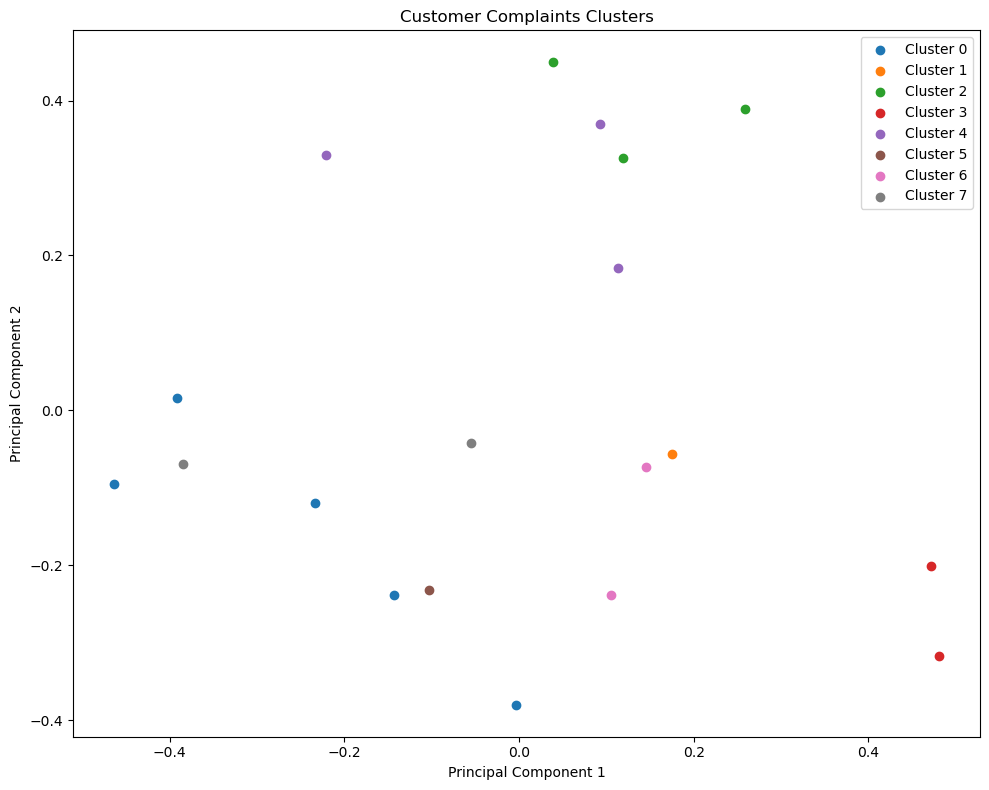

In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from tabulate import tabulate
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Define preprocessing function
def preprocess_text(text):
    # Handle NaN values
    if isinstance(text, float) and np.isnan(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into string
    processed_text = ' '.join(tokens)
    
    return processed_text

# Load customer complaints dataset
# Assuming the file is in the current directory
df = pd.read_csv('customer_complaints_1.csv')

# Check the dataset
print("Dataset Info:")
print(f"Number of rows: {df.shape[0]}")
print(f"Columns: {df.columns.tolist()}")
print("\nSample complaints:")
print(df['text'].head())

# Preprocess the text data
print("\nPreprocessing text data...")
df['processed_text'] = df['text'].apply(preprocess_text)

# Show sample of processed text
print("\nSample processed complaints:")
for i in range(3):
    print(f"Original: {df['text'].iloc[i][:100]}...")
    print(f"Processed: {df['processed_text'].iloc[i][:100]}...")
    print("-" * 50)

# TF-IDF Vectorization
print("\nApplying TF-IDF vectorization...")
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df['processed_text'])
print(f"TF-IDF shape: {X_tfidf.shape}")

# Determine optimal number of clusters using silhouette score
def find_optimal_clusters(X, max_clusters=10):
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"For n_clusters = {k}, silhouette score is {silhouette_avg}")
    return silhouette_scores

print("\nFinding optimal number of clusters...")
# Use a subsample for faster computation
sample_size = min(X_tfidf.shape[0], 1000)
indices = np.random.choice(X_tfidf.shape[0], sample_size, replace=False)
X_sample = X_tfidf[indices]

silhouette_scores = find_optimal_clusters(X_sample, max_clusters=8)

# Determine optimal k
optimal_k = np.argmax(silhouette_scores) + 2  # +2 because we start from k=2
print(f"\nOptimal number of clusters based on silhouette score: {optimal_k}")

# Perform K-means clustering with optimal k
print(f"\nPerforming K-means clustering with k={optimal_k}...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_tfidf)

# Summary of clusters
print("\nCluster Distribution:")
cluster_counts = df['cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} complaints ({count/len(df)*100:.2f}%)")

# Extract top terms for each cluster
print("\nTop terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(optimal_k):
    print(f"\nCluster {i} top terms:")
    for ind in order_centroids[i, :15]:
        print(f' {terms[ind]}')

# Sample complaints from each cluster
print("\nSample complaints from each cluster:")
for i in range(optimal_k):
    print(f"\n--- CLUSTER {i} SAMPLES ---")
    cluster_samples = df[df['cluster'] == i]['text'].sample(min(3, len(df[df['cluster'] == i]))).tolist()
    for j, sample in enumerate(cluster_samples):
        print(f"Sample {j+1}: {sample[:200]}...")
        
# Visualize clusters with PCA for dimensionality reduction
print("\nVisualizing clusters with PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 8))
for i in range(optimal_k):
    plt.scatter(X_pca[df['cluster'] == i, 0], X_pca[df['cluster'] == i, 1], label=f'Cluster {i}')

plt.title('Customer Complaints Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('customer_complaints_clusters.png')
print("Visualization saved as 'customer_complaints_clusters.png'")

# Calculate purity
total_samples = len(df['cluster'])
cluster_label_counts = [Counter(df['cluster'])]
purity = sum(max(cluster.values()) for cluster in cluster_label_counts) / total_samples
print(f"\nPurity: {purity}")

# Summarize the main topics for each cluster
print("\nMain topics for each cluster:")
for i in range(optimal_k):
    print(f"\nCluster {i} seems to be about:")
    top_words = [terms[ind] for ind in order_centroids[i, :10]]
    print(", ".join(top_words))
    
    # Calculate most common words in the cluster
    cluster_text = " ".join(df[df['cluster'] == i]['processed_text'])
    cluster_words = cluster_text.split()
    word_count = Counter(cluster_words)
    most_common = word_count.most_common(5)
    print(f"Most frequent words: {', '.join([word for word, count in most_common])}")
    
    # Get a sample complaint
    sample = df[df['cluster'] == i]['text'].iloc[0][:150] + "..."
    print(f"Sample complaint: {sample}")